In [22]:
import sys
import os
sys.path.append(os.path.abspath("../.."))

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random

from models.lstm import LSTMRegressor
from models.kan_encoder import KANEncoder
from utils.stock_data import get_log_return_loaders, StockIndex
from utils.early_stopping import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [23]:
BEST_LSTM_PARAMS = {
    StockIndex.NVDA: {
        "hidden_dim": 192,
        "num_layers": 3,
        "dropout": 0.22832671613107025,
        "batch_size": 16,
        "lr": 0.001025807645705379
    },
    StockIndex.AAPL: {
        "hidden_dim": 32,
        "num_layers": 2,
        "dropout": 0.1879585812618099,
        "batch_size": 64,
        "lr": 0.00016388823896781193
    },
    StockIndex.KO: {
        "hidden_dim": 32,
        "num_layers": 1,
        "dropout": 0.15532586065977919,
        "batch_size": 64,
        "lr": 0.0010746245334922824
    }
}

BEST_KAN_PARAMS = {
    StockIndex.NVDA: {
        "kan_hidden_dim": 7,
        "grid": 19,
        "k": 4,
        "lambda_reg": 0.0005318964548329693,
        "lamb_entropy": 1.2079842821662439,
        "lamb_l1": 0.6404082359636214,
        "lr": 0.004182035354893474
    },
    StockIndex.AAPL: {
        "kan_hidden_dim": 7,
        "grid": 7,
        "k": 4,
        "lambda_reg": 4.4023687865344134e-05,
        "lamb_entropy": 1.3601534274818794,
        "lamb_l1": 1.5776285378778048,
        "lr": 0.009929099288524628
    },
    StockIndex.KO: {
        "kan_hidden_dim": 9,
        "grid": 11,
        "k": 5,
        "lambda_reg": 2.3551891814555216e-05,
        "lamb_entropy": 1.4982307075468073,
        "lamb_l1": 0.30748485072225795,
        "lr": 0.0014451741202787993
    }
}

## Training KAN -> LSTM for each stock ##

### NVIDIA ###

In [24]:
stock = StockIndex.NVDA
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

checkpoint directory created: ./kan_model
saving model version 0.0
Epoch 1: Train Loss = 0.001282 | Val Loss = 0.000748
Epoch 2: Train Loss = 0.001115 | Val Loss = 0.000723
Epoch 3: Train Loss = 0.001125 | Val Loss = 0.000685
Epoch 4: Train Loss = 0.001104 | Val Loss = 0.000711
Epoch 5: Train Loss = 0.001106 | Val Loss = 0.000704
Epoch 6: Train Loss = 0.001110 | Val Loss = 0.000694
Epoch 7: Train Loss = 0.001099 | Val Loss = 0.000694
Epoch 8: Train Loss = 0.001108 | Val Loss = 0.000687
Epoch 9: Train Loss = 0.001106 | Val Loss = 0.000689
Epoch 10: Train Loss = 0.001090 | Val Loss = 0.000685
Epoch 11: Train Loss = 0.001096 | Val Loss = 0.000684
Epoch 12: Train Loss = 0.001096 | Val Loss = 0.000685
Epoch 13: Train Loss = 0.001095 | Val Loss = 0.000688
Epoch 14: Train Loss = 0.001094 | Val Loss = 0.000696
Epoch 15: Train Loss = 0.001097 | Val Loss = 0.000684
Epoch 16: Train Loss = 0.001087 | Val Loss = 0.000731
Epoch 17: Train Loss = 0.001096 | Val Loss = 0.000687
Epoch 18: Train Loss = 0

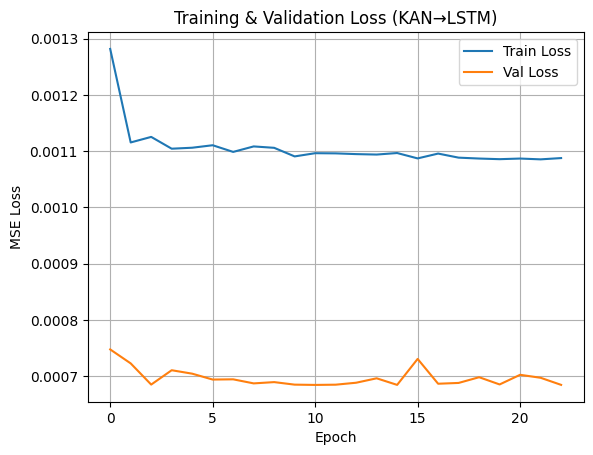

In [25]:
nvda_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

nvda_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': nvda_encoder.parameters(), 'lr': kan_params['lr']},
    {'params': nvda_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    nvda_encoder.train()
    nvda_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        encoded = nvda_encoder(xb)
        preds = nvda_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = nvda_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )

        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    nvda_encoder.eval()
    nvda_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = nvda_encoder(xb)
            preds = nvda_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.003159178
Std of predicted return: 7.3714085e-10
Mean actual return: 0.002643923
Std of actual return: 0.032575168
Test RMSE: 3.8701
Test MAE : 3.0028


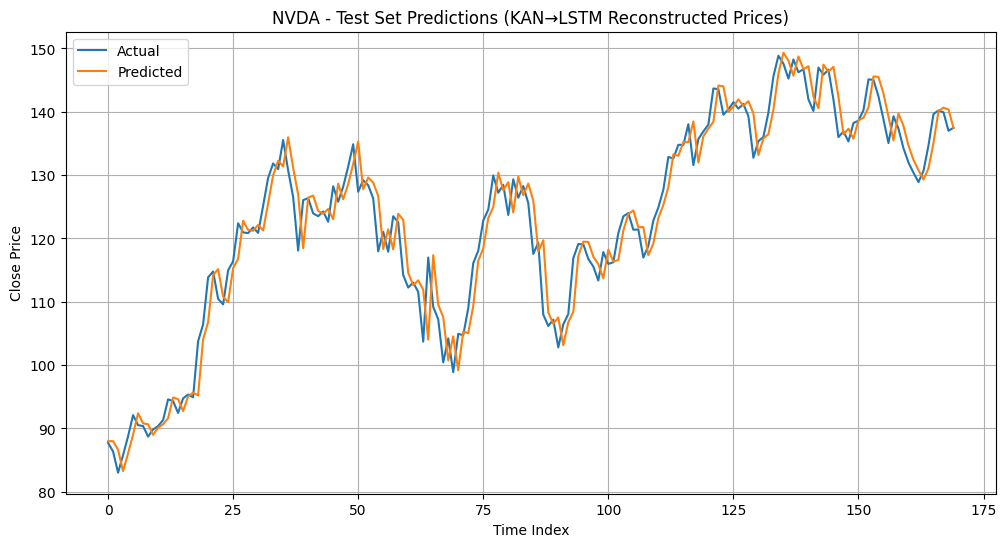

In [26]:
nvda_encoder.eval()
nvda_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = nvda_encoder(xb)
        y_pred = nvda_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


### Apple ###

In [12]:
stock = StockIndex.AAPL
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.000469 | Val Loss = 0.000174
Epoch 2: Train Loss = 0.000431 | Val Loss = 0.000178
Epoch 3: Train Loss = 0.000432 | Val Loss = 0.000182
Epoch 4: Train Loss = 0.000426 | Val Loss = 0.000186
Epoch 5: Train Loss = 0.000433 | Val Loss = 0.000184
Epoch 6: Train Loss = 0.000432 | Val Loss = 0.000169
Epoch 7: Train Loss = 0.000436 | Val Loss = 0.000168
Epoch 8: Train Loss = 0.000435 | Val Loss = 0.000175
Epoch 9: Train Loss = 0.000461 | Val Loss = 0.000172
Epoch 10: Train Loss = 0.000459 | Val Loss = 0.000169
Epoch 11: Train Loss = 0.000481 | Val Loss = 0.000183
Epoch 12: Train Loss = 0.000474 | Val Loss = 0.000171
Epoch 13: Train Loss = 0.000465 | Val Loss = 0.000176
Epoch 14: Train Loss = 0.000458 | Val Loss = 0.000173
Epoch 15: Train Loss = 0.000460 | Val Loss = 0.000169
Epoch 16: Train Loss = 0.000458 | Val Loss = 0.000169
Epoch 17: Train Loss = 0.000472 | Val Loss = 0.000186
Epoch 18: Train Loss = 0.000461 | Val Loss = 0.000169
Epoch 19: Train Loss = 0.000453 | Val

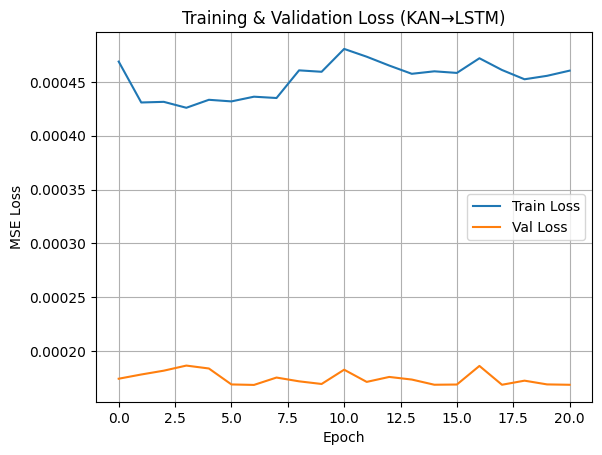

In [13]:
aapl_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

aapl_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': aapl_encoder.parameters(), 'lr': kan_params['lr']},
    {'params': aapl_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    aapl_encoder.train()
    aapl_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = aapl_encoder(xb)
        preds = aapl_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = aapl_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )

        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    aapl_encoder.eval()
    aapl_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = aapl_encoder(xb)
            preds = aapl_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: -8.039807e-06
Std of predicted return: 8.208673e-09
Mean actual return: 0.002365659
Std of actual return: 0.014482381
Test RMSE: 3.1271
Test MAE : 2.2889


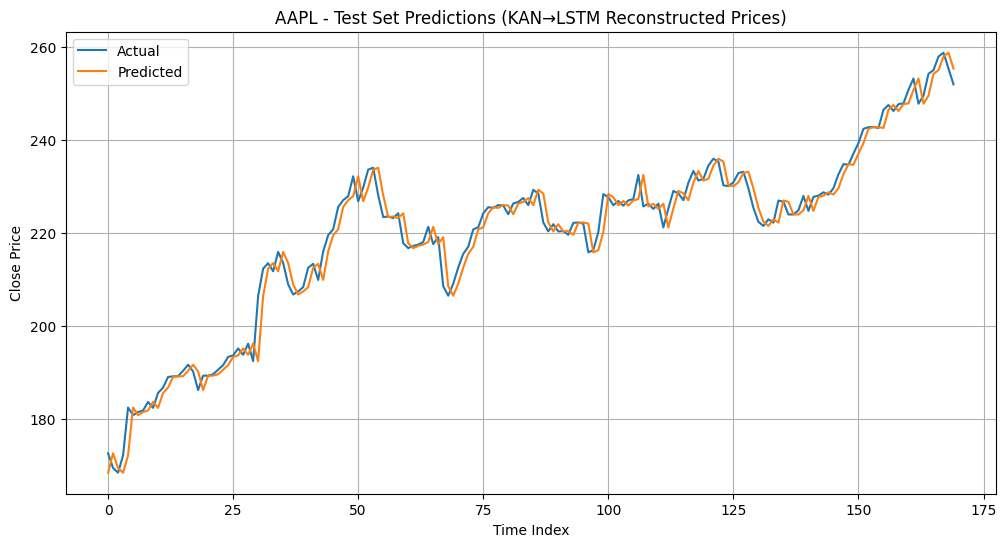

In [14]:
aapl_encoder.eval()
aapl_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = aapl_encoder(xb)
        y_pred = aapl_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


### Coke ###

In [9]:
stock = StockIndex.KO
lstm_params = BEST_LSTM_PARAMS[stock]
kan_params = BEST_KAN_PARAMS[stock]
train_dl, val_dl, test_dl = get_log_return_loaders(
    stock,
    window_size=7,
    batch_size=lstm_params["batch_size"]
)
input_dim = next(iter(train_dl))[0].shape[-1]

Epoch 1: Train Loss = 0.001255 | Val Loss = 0.000118
Epoch 2: Train Loss = 0.000240 | Val Loss = 0.000077
Epoch 3: Train Loss = 0.000176 | Val Loss = 0.000070
Epoch 4: Train Loss = 0.000176 | Val Loss = 0.000070
Epoch 5: Train Loss = 0.000177 | Val Loss = 0.000073
Epoch 6: Train Loss = 0.000175 | Val Loss = 0.000070
Epoch 7: Train Loss = 0.000176 | Val Loss = 0.000070
Epoch 8: Train Loss = 0.000176 | Val Loss = 0.000075
Epoch 9: Train Loss = 0.000175 | Val Loss = 0.000070
Epoch 10: Train Loss = 0.000175 | Val Loss = 0.000073
Epoch 11: Train Loss = 0.000175 | Val Loss = 0.000076
Epoch 12: Train Loss = 0.000175 | Val Loss = 0.000072
Epoch 13: Train Loss = 0.000175 | Val Loss = 0.000072
Epoch 14: Train Loss = 0.000177 | Val Loss = 0.000070
Epoch 15: Train Loss = 0.000175 | Val Loss = 0.000070
Epoch 16: Train Loss = 0.000175 | Val Loss = 0.000070
Epoch 17: Train Loss = 0.000176 | Val Loss = 0.000072
Epoch 18: Train Loss = 0.000178 | Val Loss = 0.000070
Epoch 19: Train Loss = 0.000177 | Val

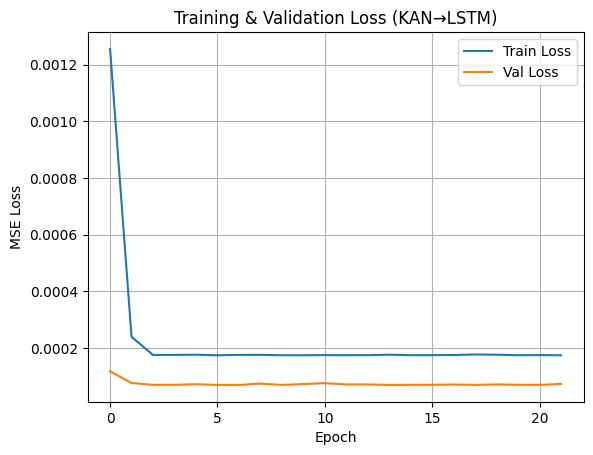

In [10]:
ko_encoder = KANEncoder(
    width=[input_dim, kan_params['kan_hidden_dim'], input_dim],
    grid=kan_params['grid'],
    k=kan_params['k'],
    affine_trainable=False,
    symbolic_enabled=False,
    device=device,
    seed=SEED
).to(device)

ko_lstm = LSTMRegressor(
    input_dim=input_dim,
    hidden_dim=lstm_params['hidden_dim'],
    num_layers=lstm_params['num_layers'],
    dropout=lstm_params['dropout']
).to(device)

optimizer = optim.Adam([
    {'params': ko_encoder.parameters(), 'lr': kan_params['lr']},
    {'params': ko_lstm.parameters(), 'lr': lstm_params['lr']}
])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
criterion = nn.MSELoss()
early_stopper = EarlyStopping(patience=20, min_delta=1e-5)

train_losses = []
val_losses = []

for epoch in range(50):
    # ---- TRAIN ----
    ko_encoder.train()
    ko_lstm.train()
    train_loss = 0.0
    for xb, yb, _ in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        encoded = ko_encoder(xb)
        preds = ko_lstm(encoded).squeeze()
        mse_loss = criterion(preds, yb)

        reg = ko_encoder.kan.get_reg(
            reg_metric="edge_forward_spline_n",
            lamb_l1=kan_params['lamb_l1'],
            lamb_entropy=kan_params['lamb_entropy'],
            lamb_coef=0.0,
            lamb_coefdiff=0.0
        )

        total_loss = mse_loss + kan_params['lambda_reg'] * reg
        total_loss.backward()
        optimizer.step()
        train_loss += mse_loss.item()

    train_loss /= len(train_dl)
    train_losses.append(train_loss)

    # ---- VALIDATE ----
    ko_encoder.eval()
    ko_lstm.eval()
    val_loss = 0.0
    with torch.no_grad():
        for xb, yb, _ in val_dl:
            xb, yb = xb.to(device), yb.to(device)
            encoded = ko_encoder(xb)
            preds = ko_lstm(encoded).squeeze()
            val_loss += criterion(preds, yb).item()
    val_loss /= len(val_dl)
    val_losses.append(val_loss)

    scheduler.step(val_loss)
    early_stopper(val_loss)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.6f} | Val Loss = {val_loss:.6f}")

    if early_stopper.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# ---- Plot ----
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Training & Validation Loss (KAN→LSTM)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.legend()
plt.show()


Mean predicted return: 0.0016802438
Std of predicted return: 9.710325e-07
Mean actual return: 0.00015766906
Std of actual return: 0.00826914
Test RMSE: 0.5483
Test MAE : 0.4150


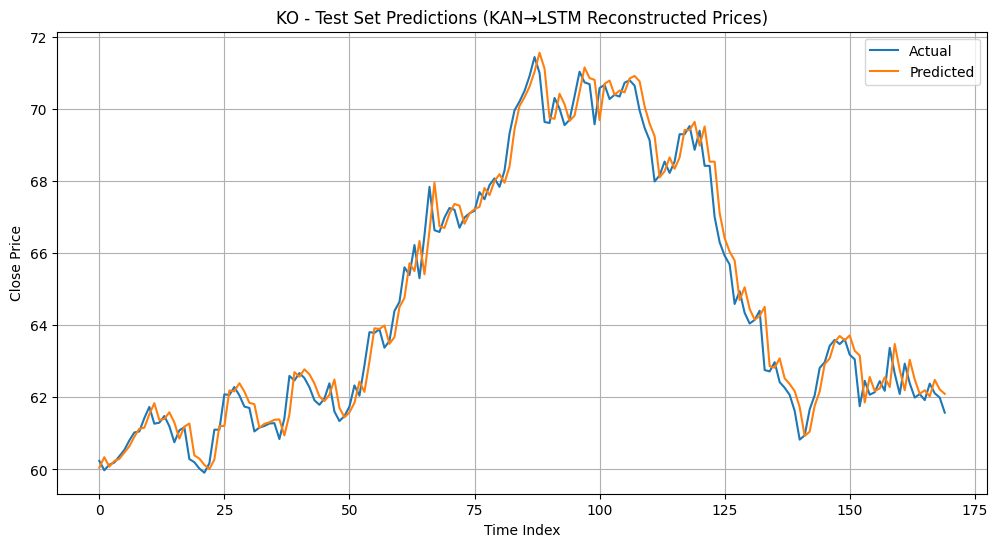

In [11]:
ko_encoder.eval()
ko_lstm.eval()

preds, targets, prev_prices = [], [], []

with torch.no_grad():
    for xb, yb, p_tm1 in test_dl:
        xb = xb.to(device)
        encoded = ko_encoder(xb)
        y_pred = ko_lstm(encoded).squeeze().cpu().numpy()

        preds.extend(y_pred)
        targets.extend(yb.numpy())
        prev_prices.extend(p_tm1.numpy())

# Convert to arrays
preds = np.array(preds)
targets = np.array(targets)
prev_prices = np.array(prev_prices)

# Reconstruct prices
pred_prices = prev_prices * np.exp(preds)
true_prices = prev_prices * np.exp(targets)

print("Mean predicted return:", np.mean(preds))
print("Std of predicted return:", np.std(preds))

print("Mean actual return:", np.mean(targets))
print("Std of actual return:", np.std(targets))

# Metrics
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae = mean_absolute_error(true_prices, pred_prices)
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE : {mae:.4f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label="Actual")
plt.plot(pred_prices, label="Predicted")
plt.title(f"{stock.value} - Test Set Predictions (KAN→LSTM Reconstructed Prices)")
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()
